May 2019 outbreak

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
import numpy as np
import re
from sklearn.linear_model import LinearRegression

In [113]:
tornado_data = pd.read_csv('may2019outbreak.csv')
tornado_data.head()

,EF#,Location,County / Parish,State,Start Coord.,Time (UTC),Path length,Max width,Summary,Refs
0,EF0,E of Fort Stockton,Pecos,TX,30°49′44″N 102°33′32″W﻿ / ﻿30.829°N 102.559°W,21:43–21:55,2 mi (3.2 km),NaN,Spotters and emergency management observed a t...,[1]
1,EF2,ESE of Culbertson to NW of McCook,Red Willow,NE,40°12′12″N 100°45′37″W﻿ / ﻿40.2034°N 100.7604°W,22:55–23:01,6 mi (9.7 km),350 yd (320 m),"This strong tornado destroyed 6 grain bins, 5 ...",[2]
2,EF0,SW of Stockville,Frontier,NE,NaN,23:32–23:33,0.1 mi (0.16 km),20 yd (18 m),A tornado briefly touched down. No damage occu...,[3]
3,EF0,Northwestern Stockville,Frontier,NE,NaN,23:45–23:46,0.1 mi (0.16 km),50 yd (46 m),A tornado briefly touched down in a field at t...,[3]
4,EF0,NE of Stockville,Frontier,NE,40°34′N 100°20′W﻿ / ﻿40.56°N 100.34°W,23:55–23:56,0.5 mi (0.80 km),315 yd (288 m),"Several 1,400 lb (640 kg) hay bales were moved...",[3]


As can be seen, this dataset has 10 columns:

EF#: The strength of the tornado, measured on the Enhance-Fujita scale.

Location
County / Parish

State

Start Coord: The latitude and longitude of the location the tornado touched down

Time: The exact time the tornado was on the ground

Path length

Max width

Summary: A brief summary of observation and damage assessment

Ref: Citation number for wikipedia

In [114]:
# Here I'll start with a breakdown of tornados first grouped by state then by EF rating. Then I can think of two useful questions:
# if width is correlated to path length and if EF is correlated to path length / width

cols = ['EF#', 'State', 'Path length', 'Max width']

tornado_data = tornado_data[cols]
tornado_data.head()

,EF#,State,Path length,Max width
0,EF0,TX,2 mi (3.2 km),NaN
1,EF2,NE,6 mi (9.7 km),350 yd (320 m)
2,EF0,NE,0.1 mi (0.16 km),20 yd (18 m)
3,EF0,NE,0.1 mi (0.16 km),50 yd (46 m)
4,EF0,NE,0.5 mi (0.80 km),315 yd (288 m)


Two columns are not yet in a useful state for analysis: Path length and Max width. We can use the regular expressions (re) library to cut the data down to just SI units. We will also takes this time to remove any rows with incomplete information, for example where the EF rating is unknown. These are quite commonly EF0-1 tornados that strike open fields and cause no damage to survey.

For tornados that crossed state lines, we will only count them for the state where they touched down.

In [115]:
tornado_data['Path length'] = tornado_data['Path length'].str.replace(r'.*\(','')
tornado_data['Path length'] = tornado_data['Path length'].str.replace(r'\s.*','')

tornado_data['Max width'] = tornado_data['Max width'].str.replace(r'.*\(','')
tornado_data['Max width'] = tornado_data['Max width'].str.replace(r'\s.*','')
tornado_data['Max width'] = tornado_data['Max width'].str.replace(',','')

tornado_data['State'] = tornado_data['State'].str.replace(r',.*','')

tornado_data = tornado_data.dropna() # drop NaN elements

tornado_data = tornado_data[tornado_data['EF#'] != 'EFU']

tornado_data.shape


(252, 4)

In [160]:
tornado_data['Path length'].value_counts()

0.16     12
1.6       8
0.32      6
0.40      6
4.2       6
6.4       5
0.80      5
0.97      4
2.4       4
9.7       4
1.8       4
2.6       4
3.4       3
8.5       3
1.21      3
3.7       3
1.3       3
1.4       3
1.1       3
2.1       3
14        2
18        2
1.9       2
12.1      2
4.3       2
0.56      2
0.48      2
8.0       2
3.5       2
0.064     2
         ..
17.45     1
13        1
14.3      1
1.43      1
6.45      1
17.85     1
6.23      1
1.53      1
51.21     1
9.5       1
20.4      1
3.1       1
8.7       1
11.1      1
9.53      1
26.6      1
11.7      1
28.53     1
8.4       1
9.25      1
9.43      1
0.72      1
5.3       1
10.67     1
35        1
15.4      1
3.62      1
8.9       1
52.11     1
0.90      1
Name: Path length, Length: 155, dtype: int64

Let's create a grouped bar plot to show the number of tornados that touched down in each state, grouped by EF rating. From the data we can find that there are several states where just a few weak tornados touched down. To simplify this graph a bit, we consider only states where at least 5 EF1s or at least one EF2 touched down. Despite this winnowing, we need to be careful to count where zero of a certain EF rating touched down in a particular state.

In [117]:
tornado_count = tornado_data.groupby(['State', 'EF#']).size()

Now we winnow the data.

In [118]:
states = ['AR','FL','LA','MD','MI','MN','ND','NJ','ID'] # states that don't meet the criteria.


tornado_slice = tornado_data

for e in states:
    tornado_slice = tornado_slice[tornado_slice['State'] != e]
    

tornado_slice
tornado_count = tornado_slice.groupby(['State','EF#']).size()

tornado_count



State  EF#
IA     EF0     6
       EF1     5
       EF2     1
       EF3     1
IL     EF0    10
       EF1    12
IN     EF0     1
       EF1     5
       EF2     2
       EF3     2
KS     EF0     4
       EF1    12
       EF2     5
       EF3     2
       EF4     1
MO     EF0     7
       EF1     7
       EF2     1
       EF3     3
NE     EF0     8
       EF1     5
       EF2     2
       EF3     1
NM     EF0     5
       EF2     1
OH     EF0     8
       EF1    10
       EF2     3
       EF3     3
       EF4     1
OK     EF0     7
       EF1    24
       EF2     5
       EF3     1
PA     EF0     7
       EF1     8
       EF2     1
TX     EF0    10
       EF1     8
       EF2     9
       EF3     5
dtype: int64

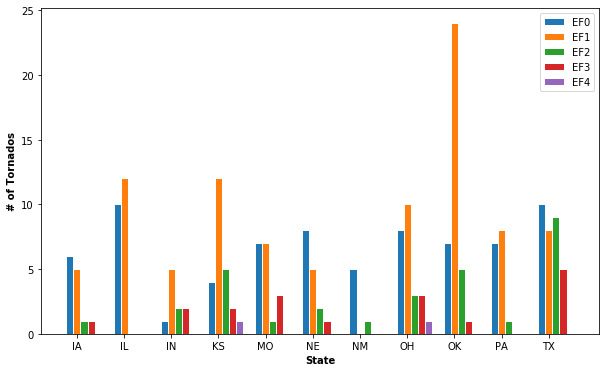

In [119]:
EF0 = []
EF1 = []
EF2 = []
EF3 = []
EF4 = []


states = ['IA','IL','IN','KS','MO','NE','NM','OH','OK','PA','TX']

for e in states:
    count = tornado_slice[tornado_slice['State'] == e]
    count = count[count['EF#'] == 'EF0'].shape[0]
    EF0.append(count)
    
    count = tornado_slice[tornado_slice['State'] == e]
    count = count[count['EF#'] == 'EF1'].shape[0]
    EF1.append(count)
    
    count = tornado_slice[tornado_slice['State'] == e]
    count = count[count['EF#'] == 'EF2'].shape[0]
    EF2.append(count)
    
    count = tornado_slice[tornado_slice['State'] == e]
    count = count[count['EF#'] == 'EF3'].shape[0]
    EF3.append(count)
    
    count = tornado_slice[tornado_slice['State'] == e]
    count = count[count['EF#'] == 'EF4'].shape[0]
    EF4.append(count)

# create plot

barWidth = 0.15

r1 = np.arange(len(EF0))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.bar(r1, EF0, width=barWidth, edgecolor='white', label='EF0')
plt.bar(r2, EF1, width=barWidth, edgecolor='white', label='EF1')
plt.bar(r3, EF2, width=barWidth, edgecolor='white', label='EF2')
plt.bar(r4, EF3, width=barWidth, edgecolor='white', label='EF3')
plt.bar(r5, EF4, width=barWidth, edgecolor='white', label='EF4')

plt.xlabel('State', fontweight='bold')
plt.ylabel('# of Tornados', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(EF0))], states)

plt.rcParams['figure.figsize'] = (10,6)

plt.legend()
plt.show()
    

Interestingly, it looks like OK had twice as many EF1 tornados than any other state, yet had roughly comparable numbers of other tornado strengths.

Texas had an interestingly even distribution of EF0-3 tornados. This is not typical, with the large majority of tornados being EF1 or less.

Let's answer two more interesting questions: whether path length and width are related or path length and EF rating are related.

In [165]:
# need to remove one row where the max width is [to be determined]. had to get a bit hacky to escape [ ]
tornado_data['Max width'] = tornado_data['Max width'].str.replace(r'.*to.*','0')
tornado_data = tornado_data[tornado_data['Max width'] != '0'] 
tornado_data['Path length'] = tornado_data['Path length'].astype(float)
tornado_data['Max width'] = tornado_data['Max width'].astype(float)
tornado_data = tornado_data.sort_values(by=['Path length'], ascending=False)


x = tornado_data.iloc[:, 2].values.reshape(-1, 1)
y = tornado_data.iloc[:, 3].values.reshape(-1, 1)

lr = LinearRegression()
lr.fit(x, y)
y_pred = lr.predict(x)
tornado_data.head(100)

,EF#,State,Path length,Max width
111,EF3,MO,52.11,1400.0
256,EF4,KS,51.21,1610.0
14,EF3,KS,42.30,550.0
254,EF2,KS,38.90,800.0
81,EF1,MO,35.00,180.0
169,EF0,NM,35.00,69.0
65,EF2,OK,34.00,2500.0
232,EF4,OH,32.00,966.0
39,EF1,LA,31.45,640.0
21,EF3,TX,30.40,1610.0


c:\programs\python\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


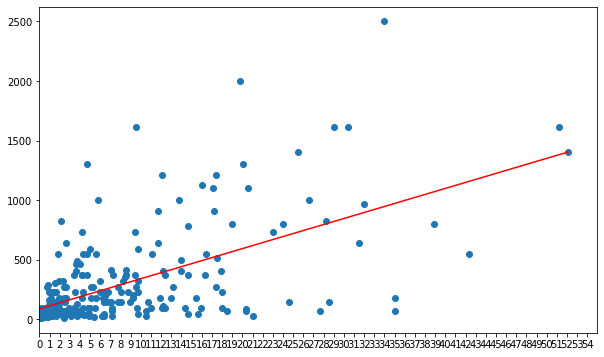

In [167]:
plt.scatter(x.ravel().tolist(), y.ravel().tolist())
ax = plt.axes()
ax.set_xlim([0,55])
ax.set_xticks(np.arange(0,55))
plt.plot(x.ravel().tolist(), y_pred, color='red')
plt.show()